In [22]:
import pandas as pd

# Load datasets
real_news_1 = pd.read_csv("D:\\Task_1\\FakeNewsNet-master\\dataset\\gossipcop_real.csv")
fake_news_1 = pd.read_csv("D:\\Task_1\\FakeNewsNet-master\\dataset\\gossipcop_fake.csv")
real_news_2 = pd.read_csv("D:\\Task_1\\FakeNewsNet-master\\dataset\\politifact_real.csv")
fake_news_2 = pd.read_csv("D:\\Task_1\\FakeNewsNet-master\\dataset\\politifact_fake.csv")
real_news_1['label'] = 1
fake_news_1['label'] = 0
real_news_2['label'] = 1
fake_news_2['label'] = 0

#Combined Real_News
combined_real_news = pd.concat([real_news_1,real_news_2],ignore_index=True)
combined_real_news['tweet_count'] = combined_real_news['tweet_ids'].apply(lambda x: len(str(x).split('\t')) if pd.notnull(x) else 0)

#Combined Fake_News
combined_fake_news = pd.concat([fake_news_1,fake_news_2],ignore_index=True)
combined_fake_news['tweet_count'] = combined_fake_news['tweet_ids'].apply(lambda x: len(str(x).split('\t')) if pd.notnull(x) else 0)



In [23]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk


stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Normalize text to lowercase
    text = text.lower()
    # Tokenize and remove stop words
    tokens = word_tokenize(text)
    text = ' '.join([word for word in tokens if word not in stop_words])
    return text

# Apply preprocessing
combined_real_news['cleaned_text'] = combined_real_news['title'].apply(preprocess_text)
combined_fake_news['cleaned_text'] = combined_fake_news['title'].apply(preprocess_text)




In [24]:
import spacy

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    entities = {'PERSON': 0, 'ORG': 0, 'GPE': 0}
    for ent in doc.ents:
        if ent.label_ in entities:
            entities[ent.label_] += 1
    return entities

# Extract entities
combined_real_news['entities'] = combined_real_news['cleaned_text'].apply(extract_entities)
combined_fake_news['entities'] = combined_fake_news['cleaned_text'].apply(extract_entities)

# Convert entities into separate columns
combined_real_news['person_count'] = combined_real_news['entities'].apply(lambda x: x['PERSON'])
combined_real_news['org_count'] = combined_real_news['entities'].apply(lambda x: x['ORG'])
combined_real_news['gpe_count'] = combined_real_news['entities'].apply(lambda x: x['GPE'])


In [25]:
from textblob import TextBlob

# Compute article length
combined_real_news['article_length'] = combined_real_news['cleaned_text'].apply(lambda x: len(x.split()))

# Compute sentiment polarity
combined_real_news['sentiment'] = combined_real_news['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Combine real and fake datasets
combined_real_news['label'] = 1
combined_fake_news['label'] = 0
data = pd.concat([combined_real_news, combined_fake_news])

# Select features and target
features = ['person_count', 'org_count', 'gpe_count', 'article_length', 'sentiment']
X = data[features]
y = data['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1164
           1       1.00      1.00      1.00      3476

    accuracy                           1.00      4640
   macro avg       1.00      1.00      1.00      4640
weighted avg       1.00      1.00      1.00      4640



In [27]:
# Correlation between tweet_count (popularity) and news type (real/fake)
correlation = data[['tweet_count', 'label']].corr()
print("Correlation between Tweet Count and News Type:")
print(correlation)

# Investigate how tweet_count differs for real vs. fake news
popular_news = data.groupby('label')['tweet_count'].mean()
print("Average Popularity (Tweet Count) for Real vs Fake News:")
print(popular_news)


Correlation between Tweet Count and News Type:
             tweet_count     label
tweet_count     1.000000 -0.051411
label          -0.051411  1.000000
Average Popularity (Tweet Count) for Real vs Fake News:
label
0    132.693484
1     74.525027
Name: tweet_count, dtype: float64


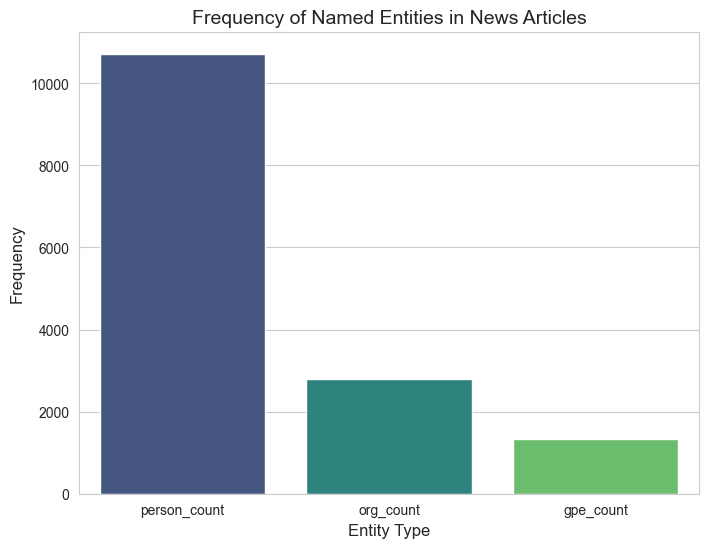

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate total counts of entities
entity_counts = data[['person_count', 'org_count', 'gpe_count']].sum()

# Plot bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=entity_counts.index, y=entity_counts.values, hue=entity_counts.index, palette="viridis")
plt.title("Frequency of Named Entities in News Articles", fontsize=14)
plt.xlabel("Entity Type", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()


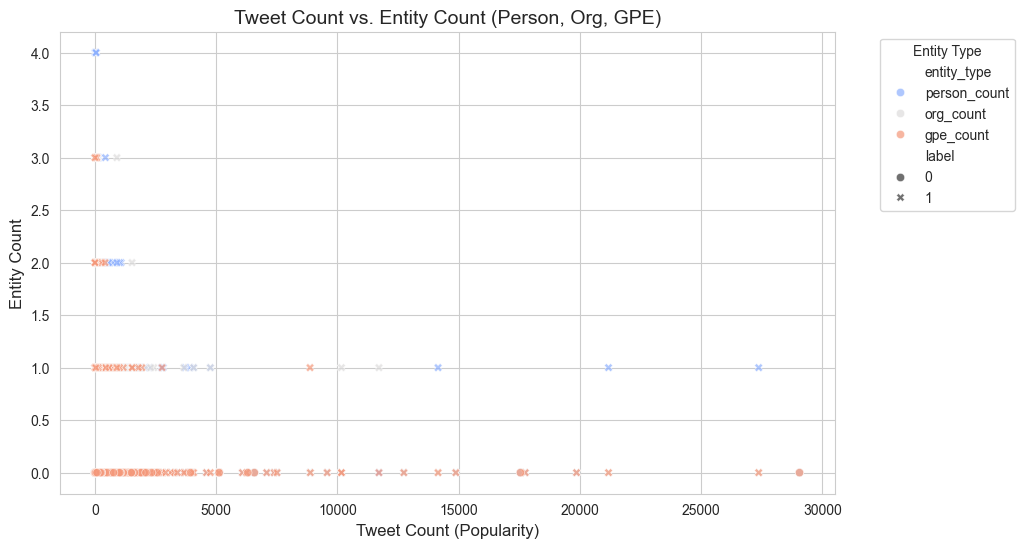

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape the data to combine the entity counts for plotting
entity_data = data[['tweet_count', 'person_count', 'org_count', 'gpe_count', 'label']]
entity_data = entity_data.melt(id_vars=['tweet_count', 'label'], 
                               value_vars=['person_count', 'org_count', 'gpe_count'], 
                               var_name='entity_type', value_name='entity_count')

# Set up the plot
plt.figure(figsize=(10, 6))

# Create the scatter plot for all three entity counts (person, org, gpe)
sns.scatterplot(x='tweet_count', y='entity_count', data=entity_data, hue='entity_type', style='label', palette='coolwarm', markers={0: 'o', 1: 'X'}, alpha=0.7)

# Set plot title and labels
plt.title('Tweet Count vs. Entity Count (Person, Org, GPE)', fontsize=14)
plt.xlabel('Tweet Count (Popularity)', fontsize=12)
plt.ylabel('Entity Count', fontsize=12)
plt.legend(title='Entity Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


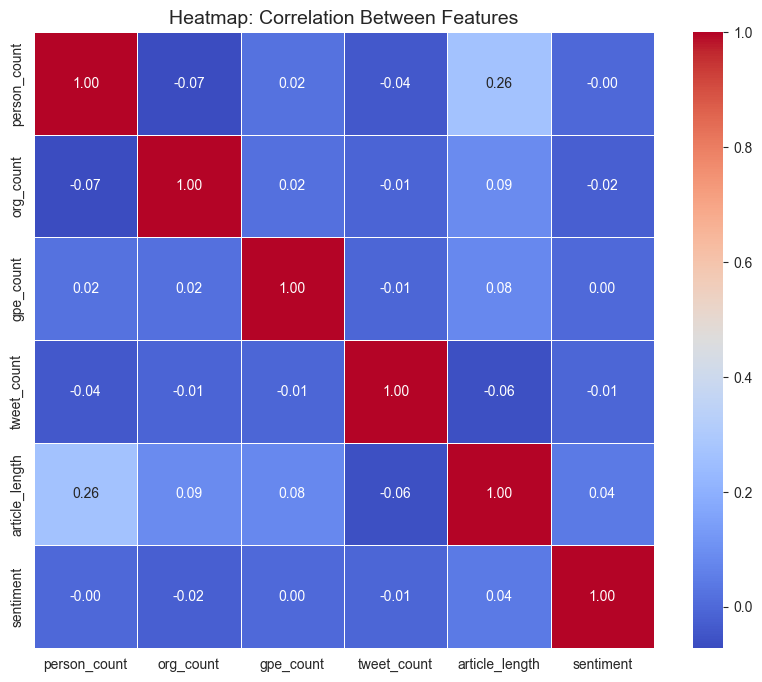

In [53]:
# Select relevant features
correlation_features = ['person_count', 'org_count', 'gpe_count', 'tweet_count', 'article_length', 'sentiment']
correlation_matrix = data[correlation_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap: Correlation Between Features", fontsize=14)
plt.show()
